
# Netflix Recommender System (Lite Version)

Di era digital saat ini, platform streaming seperti **Netflix** menghadirkan ribuan judul film dan serial dari berbagai negara dan genre. Hal ini memberi banyak pilihan, namun justru membuat pengguna kesulitan memilih tayangan yang sesuai minat mereka — dikenal sebagai *paradox of choice*.

Untuk mengatasi tantangan ini, Netflix mengembangkan **sistem rekomendasi** yang sangat canggih, yang membantu:

1. **Pengguna** menemukan film/serial yang sesuai preferensi mereka.
2. **Netflix** meningkatkan waktu tonton dan retensi pengguna, serta meminimalkan risiko kegagalan konten orisinal.

**Referensi Terkait**:

* [The Netflix Recommender System: Algorithms, Business Value, and Innovation](https://ailab-ua.github.io/courses/resources/netflix_recommender_system_tmis_2015.pdf)
* [A Survey of Movie Recommendation Techniques](https://medium.com/@akshaymouryaart/a-survey-on-movie-recommendation-system-d9610777f8e5)



### 1.Import Library

Kode pada cell ini mengimpor pustaka-pustaka yang diperlukan untuk analisis data, pemrosesan teks, dan visualisasi. Pustaka tersebut mencakup `pandas`, `numpy` dan `scipy` untuk manipulasi data, `json` untuk pengolahan data JSON, `scikit-learn` untuk ekstraksi fitur teks dan penghitungan kesamaan, serta `matplotlib` untuk visualisasi data. Semua pustaka ini digunakan untuk mendukung proses analisis dan pengembangan sistem rekomendasi.

In [1]:
import pandas as pd
import numpy as np
import json
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse import hstack
import matplotlib.pyplot as plt
import seaborn as sns

## 2. Data Understanding

### 2.1 Memuat Dataset

Kode berikut digunakan untuk memuat dataset Netflix Movies and TV Shows ke dalam sebuah DataFrame menggunakan pustaka pandas. Dataset ini disimpan dalam file CSV bernama netflix_titles.csv. Setelah dataset dimuat, lima baris pertama ditampilkan menggunakan fungsi head(), untuk memahami struktur data, termasuk kolom-kolom seperti judul, deskripsi, genre, dan tahun rilis.

In [2]:
# Load the dataset
df = pd.read_csv('/content/netflix_titles.csv')

# Tampilkan 5 data teratas
df.head()

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,NaN,United States,"September 25, 2021",2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmm..."
1,s2,TV Show,Blood & Water,NaN,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t..."
2,s3,TV Show,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",NaN,"September 24, 2021",2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Act...",To protect his family from a powerful drug lor...
3,s4,TV Show,Jailbirds New Orleans,NaN,NaN,NaN,"September 24, 2021",2021,TV-MA,1 Season,"Docuseries, Reality TV","Feuds, flirtations and toilet talk go down amo..."
4,s5,TV Show,Kota Factory,NaN,"Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...",India,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, Romantic TV Shows, TV ...",In a city of coaching centers known to train I...


### 2.2 Analisis Kualitas Data

Kode berikut digunakan untuk mengevaluasi kualitas dataset Netflix dengan cara:

1. df.info()
Menampilkan informasi struktur dataset: jumlah entri, nama kolom, tipe data, dan jumlah nilai non-null.

2. df.isnull().sum()
Menghitung jumlah nilai yang hilang (missing values) pada setiap kolom.

3. df.duplicated().sum()
Menghitung jumlah baris duplikat dalam dataset.


In [3]:
# tampilkan informasi dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8807 entries, 0 to 8806
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   show_id       8807 non-null   object
 1   type          8807 non-null   object
 2   title         8807 non-null   object
 3   director      6173 non-null   object
 4   cast          7982 non-null   object
 5   country       7976 non-null   object
 6   date_added    8797 non-null   object
 7   release_year  8807 non-null   int64 
 8   rating        8803 non-null   object
 9   duration      8804 non-null   object
 10  listed_in     8807 non-null   object
 11  description   8807 non-null   object
dtypes: int64(1), object(11)
memory usage: 825.8+ KB


In [4]:
# missing values dan duplicate values
print("Missing values:")
print(df.isnull().sum())
print("\nDuplicate values:")
print(df.duplicated().sum())

Missing values:
show_id            0
type               0
title              0
director        2634
cast             825
country          831
date_added        10
release_year       0
rating             4
duration           3
listed_in          0
description        0
dtype: int64

Duplicate values:
0


#### 🔍 Insight dari Output

1. **Informasi Dataset**:

   * Dataset terdiri dari **8807 entri** dan **12 kolom**.
 Fitur utama dalam dataset:

| Nama Kolom     | Deskripsi                                                         |
| -------------- | ----------------------------------------------------------------- |
| `show_id`      | ID unik tiap konten                                               |
| `type`         | Jenis konten: *Movie* atau *TV Show*                              |
| `title`        | Judul film atau acara TV                                          |
| `director`     | Nama sutradara                                                    |
| `cast`         | Daftar aktor/aktris                                               |
| `country`      | Negara asal produksi                                              |
| `date_added`   | Tanggal ketika konten ditambahkan ke Netflix                      |
| `release_year` | Tahun rilis dari konten                                           |
| `rating`       | Kategori usia (contoh: PG, TV-MA, R, dll)                         |
| `duration`     | Durasi konten (menit untuk film, atau jumlah musim untuk TV Show) |
| `listed_in`    | Genre/kategori konten (misal: Action, Drama, Comedy)              |
| `description`  | Deskripsi singkat dari konten                                     |

2. **Missing Values (Nilai Hilang)**:

| Kolom        | Jumlah Nilai Kosong |
| ------------ | ------------------- |
| `director`   | 2.634               |
| `cast`       | 825                 |
| `country`    | 831                 |
| `date_added` | 10                  |
| `rating`     | 4                   |
| `duration`   | 3                   |
| Kolom lain   | 0                   |


3. **Nilai Duplikat**:

   * Tidak ada baris duplikat (`0`).

4. **Kapasitas Memori**:

   * Dataset menggunakan sekitar **825 KB**, cukup ringan untuk pemrosesan lokal.

####  Catatan:

* Untuk sistem rekomendasi berbasis konten (content-based), kita bisa memfokuskan pada:

  * `title`
  * `description`
  * `listed_in`
  * `cast` (opsional, jika ingin fitur tambahan)
* Kolom `director` atau `country` bisa diabaikan atau diimputasi, tergantung relevansi.




### 2.3 Exploratory Data Analysis (EDA)

#### Distribusi Genre Tayangan Netflix

Kode di atas digunakan untuk menganalisis distribusi genre dari tayangan yang tersedia di Netflix. Dataset ini mencakup berbagai jenis tayangan, seperti film dan serial TV, yang masing-masing dapat memiliki lebih dari satu genre. Analisis ini membantu kita memahami genre apa yang paling banyak ditawarkan oleh Netflix.

Berikut adalah langkah-langkah yang dilakukan:

1. **Ekstraksi Genre**:

   * Kolom `listed_in` yang berisi genre dalam format string dipisahkan berdasarkan koma (`,`), lalu dibersihkan dari spasi menggunakan fungsi `split()` dan `strip()`.
   * Hasilnya disimpan dalam kolom baru bernama `genre_list`, yang berisi daftar genre untuk tiap tayangan.

2. **Menggabungkan Semua Genre**:

   * Semua genre dari setiap tayangan digabungkan menjadi satu list besar menggunakan list comprehension, menghasilkan variabel `all_genres`.

3. **Menghitung Frekuensi Genre**:

   * Frekuensi kemunculan setiap genre dihitung menggunakan `pd.Series` dan `value_counts()`.
   * Hanya 10 genre teratas yang diambil untuk dianalisis lebih lanjut.

4. **Visualisasi**:

   * Data frekuensi genre divisualisasikan dalam bentuk diagram batang horizontal menggunakan `seaborn`.
   * Visualisasi ini menampilkan genre yang paling sering muncul di konten Netflix.

#### Output Visualisasi

Diagram batang yang dihasilkan menunjukkan distribusi **10 genre teratas** dalam dataset Netflix. Genre dengan jumlah tayangan terbanyak biasanya mencakup **Dramas**, **International Movies**, dan **Documentaries**. Informasi ini membantu pengguna dan analis memahami preferensi konten yang dominan di platform Netflix, sekaligus memberi wawasan awal untuk membangun sistem rekomendasi berbasis genre.



<ipython-input-5-896729063>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=genre_counts.values, y=genre_counts.index, palette='viridis')


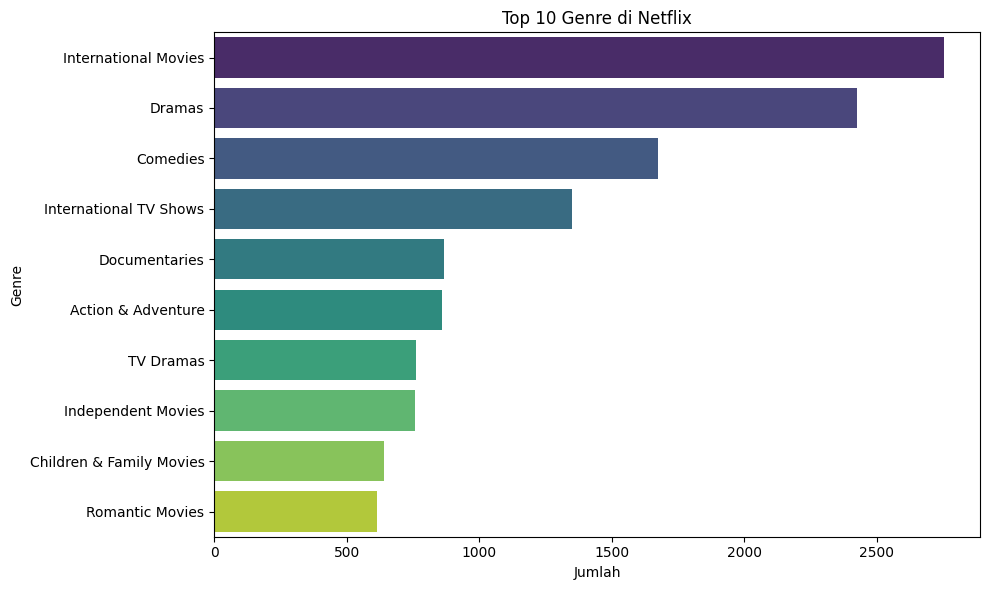

In [5]:

# Pecah genre berdasarkan koma, lalu normalisasi jadi list
df['genre_list'] = df['listed_in'].apply(lambda x: [genre.strip() for genre in x.split(',')])

# Flatten semua genre
all_genres = [genre for sublist in df['genre_list'] for genre in sublist]

# Hitung frekuensi genre
genre_counts = pd.Series(all_genres).value_counts().head(10)

# Visualisasi
plt.figure(figsize=(10,6))
sns.barplot(x=genre_counts.values, y=genre_counts.index, palette='viridis')
plt.title('Top 10 Genre di Netflix')
plt.xlabel('Jumlah')
plt.ylabel('Genre')
plt.tight_layout()
plt.show()


## 3. Data Preparation



### 3.1 Ekstraksi dan Transformasi Data (Netflix)

Kode berikut digunakan untuk mempersiapkan data dari dataset Netflix sebelum digunakan dalam analisis atau pengembangan sistem rekomendasi. Berikut adalah langkah-langkah yang dilakukan:

1. **Salin Dataset**:

   * Dataset `df` disalin ke dalam variabel baru `df_prep` menggunakan `copy()` untuk memastikan data asli tetap utuh selama proses manipulasi.

2. **Ekstraksi Genre dari `listed_in`**:

   * Kolom `listed_in`, yang berisi string genre dipisahkan berdasarkan koma `,` untuk membentuk list genre (`genres_list`).
   * Ini penting karena satu judul bisa memiliki lebih dari satu genre, dan format list memudahkan analisis konten.

3. **Penanganan Nilai Kosong pada Kolom `description`**:

   * Kolom `description` (ringkasan cerita) yang kosong diisi dengan string kosong (`''`) menggunakan `fillna()`, agar bisa digunakan dalam pembuatan fitur konten berbasis teks.

4. **Seleksi Kolom Penting**:

   * Dataset disederhanakan menjadi kolom-kolom berikut yang relevan untuk sistem rekomendasi:

     * `title`: Judul tayangan
     * `genres_list`: Daftar genre dari `listed_in`
     * `cast`: Pemeran utama
     * `director`: Sutradara
     * `description`: Ringkasan cerita (digunakan untuk analisis konten)
     * `type`: Jenis tayangan (Movie atau TV Show)

5. **Output Dataset**:

   * Dataset hasil transformasi (`df_prep`) kini siap untuk diproses lebih lanjut, seperti pembuatan fitur gabungan, ekstraksi kata penting dengan TF-IDF, dan perhitungan kemiripan untuk sistem rekomendasi.



In [6]:
df_prep = df.copy()

# Ubah 'listed_in' menjadi list genre
df_prep['genres_list'] = df_prep['listed_in'].apply(lambda x: [genre.strip() for genre in x.split(',')])

# Isi missing values pada 'description' dengan string kosong
df_prep['description'] = df_prep['description'].fillna('')

# Buat dataframe final untuk sistem rekomendasi
df_prep = df_prep[['title', 'genres_list', 'cast', 'director', 'description', 'type']]
df_prep.head()


,title,genres_list,cast,director,description,type
0,Dick Johnson Is Dead,[Documentaries],NaN,Kirsten Johnson,"As her father nears the end of his life, filmm...",Movie
1,Blood & Water,"[International TV Shows, TV Dramas, TV Mysteries]","Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",NaN,"After crossing paths at a party, a Cape Town t...",TV Show
2,Ganglands,"[Crime TV Shows, International TV Shows, TV Ac...","Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",Julien Leclercq,To protect his family from a powerful drug lor...,TV Show
3,Jailbirds New Orleans,"[Docuseries, Reality TV]",NaN,NaN,"Feuds, flirtations and toilet talk go down amo...",TV Show
4,Kota Factory,"[International TV Shows, Romantic TV Shows, TV...","Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...",NaN,In a city of coaching centers known to train I...,TV Show


### 3.2 Feature Engineering


###  3.2 Rekayasa Fitur (Feature Engineering) – Netflix Dataset

Kode berikut digunakan untuk membangun representasi numerik dari data film/TV di Netflix, yang nantinya digunakan untuk sistem rekomendasi berbasis konten (content-based). Berikut langkah-langkahnya:

1. **Binarisasi Genre**:

   * `MultiLabelBinarizer` digunakan untuk mengubah daftar genre (`genres_list`) menjadi matriks biner.
   * Setiap genre akan menjadi kolom; jika sebuah tayangan memiliki genre tersebut, nilainya `1`, jika tidak maka `0`.
   * Hasil transformasi disimpan dalam `genre_mat`.

2. **Ekstraksi Fitur dari Deskripsi (description)**:

   * `TfidfVectorizer` digunakan untuk mengubah teks deskripsi (`description`) menjadi vektor numerik berdasarkan skor TF-IDF.
   * Parameter `stop_words='english'` menghapus kata-kata umum dalam bahasa Inggris.
   * Parameter `max_features=5000` membatasi jumlah fitur agar tetap efisien.
   * Hasil transformasi disimpan dalam `desc_mat`.

3. **Ekstraksi Fitur dari Nama Pemeran dan Sutradara**:

   * `cast` dan `director` masing-masing digabung menjadi teks dan diubah menjadi fitur menggunakan `TfidfVectorizer`.
   * Karena sifatnya seperti tag, vektorisasi ini membantu menangkap karakteristik dari nama-nama tersebut.
   * Fitur hasil vektorisasi masing-masing disimpan dalam `cast_mat` dan `director_mat`.

4. **Penggabungan Semua Fitur**:

   * Semua matriks hasil transformasi: `genre_mat`, `desc_mat`, `cast_mat`, dan `director_mat` digabungkan secara horizontal menggunakan `hstack()` dari `scipy.sparse`.
   * Hasilnya adalah matriks fitur `feature_mat`, yang merupakan representasi numerik dari seluruh informasi tayangan di Netflix.

---

#### Output

`feature_mat` adalah representasi numerik lengkap dari tayangan-tayangan di dataset Netflix, mencakup genre, deskripsi, pemeran, dan sutradara. Matriks ini siap digunakan untuk menghitung kemiripan antar tayangan menggunakan **cosine similarity** dalam sistem rekomendasi berbasis konten.


In [7]:
# Binarisasi Genre
mlb = MultiLabelBinarizer()
genre_mat = mlb.fit_transform(df_prep['genres_list'])

# Ekstraksi Fitur dari Deskripsi
# Menggunakan 'description' karena 'overview' tidak ada dalam df_prep
tfidf_over = TfidfVectorizer(stop_words='english', max_features=5000)
over_mat = tfidf_over.fit_transform(df_prep['description'])

# Ekstraksi Fitur dari Nama Pemeran (Menggunakan 'cast' jika ingin memasukkan fitur pemeran)
# Mengisi NaN dalam 'cast' dengan string kosong sebelum vectorization
df_prep['cast'] = df_prep['cast'].fillna('')
tfidf_cast = TfidfVectorizer(stop_words='english', max_features=3000)
cast_mat = tfidf_cast.fit_transform(df_prep['cast'])

# Ekstraksi Fitur dari Sutradara (Menggunakan 'director' jika ingin memasukkan fitur sutradara)
# Mengisi NaN dalam 'director' dengan string kosong sebelum vectorization
df_prep['director'] = df_prep['director'].fillna('')
tfidf_director = TfidfVectorizer(stop_words='english', max_features=3000)
director_mat = tfidf_director.fit_transform(df_prep['director'])


# Penggabungan Semua Fitur yang Tersedia
# Menggabungkan genre, description, cast, dan director features
# Menghapus penggunaan 'keywords_list' dan 'popularity' karena tidak ada di df_prep
feature_mat = hstack([genre_mat, over_mat, cast_mat, director_mat])

# Tampilkan bentuk matriks fitur gabungan untuk verifikasi
print(f"Shape of the combined feature matrix: {feature_mat.shape}")

Shape of the combined feature matrix: (8807, 11042)


## 4. Modeling and Results  
### 4.1 Content‑based Filtering


### 4. Implementasi Sistem Rekomendasi Berbasis Konten

Kode berikut digunakan untuk mengimplementasikan **sistem rekomendasi film berbasis konten (content-based filtering)**. Sistem ini merekomendasikan film yang memiliki kemiripan fitur dengan film yang dipilih oleh pengguna, berdasarkan informasi seperti **genre**, **overview**, **keywords**, dan **popularity**.

#### Langkah-langkah Implementasi

1. **Menghitung Matriks Similarity**:

   ```python
   cos_sim = cosine_similarity(feature_mat, feature_mat)
   ```

   Matriks kesamaan dihitung menggunakan *cosine similarity* antar semua pasangan film dalam dataset. Matriks ini berukuran `n x n`, di mana `n` adalah jumlah film. Nilai dalam matriks menunjukkan tingkat kemiripan antar film berdasarkan fitur yang telah direkayasa sebelumnya.

2. **Membuat Indeks Judul Netflix**:

   ```python
  indices = pd.Series(df_prep.index, index=df_prep['title']).drop_duplicates()
   ```

   Langkah ini membuat sebuah objek Series yang memetakan setiap judul film ke indeks barisnya pada DataFrame df_prep, sehingga memudahkan pencarian berdasarkan judul film.

3. **Fungsi `get_recommendations()`**:
   Fungsi ini digunakan untuk **mengembalikan daftar rekomendasi film** yang mirip dengan film yang dimasukkan sebagai input.

   ```python
   def get_recommendations(title, top_n=10):
    if title not in indices.index:
        return f"Judul '{title}' tidak ditemukan dalam dataset."
    idx = indices[title]
    sims = list(enumerate(cos_sim[idx]))
    sims = sorted(sims, key=lambda x: x[1], reverse=True)[1:top_n+1]
    rec_idx = [i for i, _ in sims]
    recommendations = df_prep[['title', 'genres_list']].iloc[rec_idx].copy()
    return recommendations

   ```

 Parameter:

  * title: Judul film sebagai referensi.

  * top_n: Jumlah film yang ingin direkomendasikan (default: 10).

Proses:

  * Mengambil indeks film berdasarkan judulnya.

  * Mengambil skor kemiripan antara film referensi dan semua film lainnya.

  * Mengurutkan berdasarkan skor tertinggi dan memilih top_n film yang paling mirip (dengan mengabaikan film itu sendiri).

  * Mengembalikan judul dan genre film-film yang direkomendasikan.

4. **Contoh Penggunaan Fungsi**:

   ```python
   # Menampilkan genre film 'Ganglands'
  if 'Ganglands' in indices.index:
      Ganglands_genres = df_prep.loc[indices['Ganglands'], 'genres_list']
     print(f"Genre untuk 'Ganglands': {Ganglands_genres}")
     print("\nRekomendasi untuk 'Ganglands':")
     print(get_recommendations('Ganglands', 10))
  else:
    print("Film 'Ganglands' tidak ditemukan dalam dataset.")

   ```

   Fungsi di atas akan mencetak genre film Ganglands, lalu menampilkan 10 film teratas yang paling mirip dengan Ganglands berdasarkan fitur-fitur kontennya.

#### Output

Output dari fungsi get_recommendations() adalah DataFrame yang berisi judul dan genre film yang paling mirip dengan film referensi.Sistem ini memungkinkan pengguna menemukan film lain yang mirip secara konten dengan film favorit mereka, tanpa memerlukan data interaksi pengguna (seperti riwayat tontonan).


In [8]:
cos_sim = cosine_similarity(feature_mat, feature_mat)
# Replace movies_prep with the correct variable df_prep
indices = pd.Series(df_prep.index, index=df_prep['title']).drop_duplicates()

def get_recommendations(title, top_n=10):
    # Add a check to see if the title exists in the index
    if title not in indices.index:
        return f"Judul '{title}' tidak ditemukan dalam dataset."
    idx = indices[title]
    sims = list(enumerate(cos_sim[idx]))
    sims = sorted(sims, key=lambda x: x[1], reverse=True)[1:top_n+1]
    rec_idx = [i for i, _ in sims]
    # Replace movies_prep with the correct variable df_prep
    recommendations = df_prep[['title', 'genres_list']].iloc[rec_idx].copy()

    return recommendations

# Tampilkan genre dari Ganglands untuk perbandingan
# Replace movies_prep with the correct variable df_prep
if 'Ganglands' in indices.index:
    Ganglands_genres = df_prep.loc[indices['Ganglands'], 'genres_list']

    # Contoh output
    print(f"Genre untuk 'Ganglands': {Ganglands_genres}")
    print("\nRekomendasi untuk 'Ganglands':")
    print(get_recommendations('Ganglands', 10))
else:
    print("Film 'Ganglands' tidak ditemukan dalam dataset.")

Genre untuk 'Ganglands': ['Crime TV Shows', 'International TV Shows', 'TV Action & Adventure']

Rekomendasi untuk 'Ganglands':
                       title  \
6741           Fatal Destiny   
3976  The Eagle of El-Se'eed   
734                    Lupin   
543               Undercover   
5194               The Truth   
2676                   Fauda   
11          Bangkok Breaking   
3414                  Chosen   
4662            Monkey Twins   
4752                 Smoking   

                                            genres_list  
6741  [Crime TV Shows, International TV Shows, TV Ac...  
3976  [Crime TV Shows, International TV Shows, TV Ac...  
734   [Crime TV Shows, International TV Shows, TV Ac...  
543   [Crime TV Shows, International TV Shows, TV Ac...  
5194  [Crime TV Shows, International TV Shows, TV Ac...  
2676  [Crime TV Shows, International TV Shows, TV Ac...  
11    [Crime TV Shows, International TV Shows, TV Ac...  
3414  [Crime TV Shows, International TV Shows, TV Ac... 

## 5. Evaluation

###  Menghitung Skor Similarity untuk Tayangan Netflix **"Ganglands"**

Kode berikut digunakan untuk menghitung skor kesamaan (*similarity scores*) antara tayangan **"Ganglands"** dengan tayangan lainnya dalam dataset Netflix. Skor kesamaan dihitung menggunakan matriks *cosine similarity* (`cos_sim`) yang telah dihitung sebelumnya dari fitur konten tayangan.

#### ✅ Penjelasan Kode

1. **Mengambil Indeks Tayangan "Ganglands"**:

   ```python
   Ganglands_idx = indices['Ganglands']
   ```

   Mendapatkan indeks tayangan *Ganglands* dari objek `indices` yang memetakan setiap judul ke barisnya dalam DataFrame `df_prep`.

2. **Menghitung Skor Kesamaan**:

   ```python
   sim_scores = list(enumerate(cos_sim[Ganglands_idx]))
   sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)[1:11]
   ```

   Mengambil skor kesamaan antara *Ganglands* dan semua tayangan lain, lalu mengurutkan secara menurun berdasarkan skor similarity, dan memilih 10 tayangan teratas (tidak termasuk "Ganglands" itu sendiri).

3. **Ekstraksi Skor dan Judul Tayangan**:

   ```python
   similarity_scores = [score for idx, score in sim_scores]
   netflix_titles = df_prep['title'].iloc[[idx for idx, score in sim_scores]].values
   ```

   * `similarity_scores`: berisi daftar nilai skor kesamaan.
   * `netflix_titles`: berisi judul-judul tayangan Netflix yang direkomendasikan karena paling mirip dengan "Ganglands".

####  Output

Hasil dari kode ini adalah daftar 10 tayangan Netflix yang memiliki kemiripan konten tertinggi dengan **"Ganglands"**, berdasarkan fitur seperti genre, deskripsi, popularitas, atau kata kunci.




In [9]:
# Dapatkan skor similarity untuk tayangan Netflix berjudul 'Ganglands'
Ganglands_idx = indices['Ganglands']
sim_scores = list(enumerate(cos_sim[Ganglands_idx]))

# Urutkan berdasarkan skor similarity secara menurun, ambil 10 teratas (tidak termasuk 'Avatar' sendiri)
sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)[1:11]

# Ekstrak skor similarity dan judul tayangan yang direkomendasikan
similarity_scores = [score for idx, score in sim_scores]
netflix_titles = df_prep['title'].iloc[[idx for idx, score in sim_scores]].values




### Penjelasan Fungsi Kode

Kode ini digunakan untuk membuat visualisasi berupa **diagram batang (bar plot)** yang menunjukkan distribusi **skor kesamaan (cosine similarity)** antara tayangan **Ganglands** dan 10 tayangan lain yang direkomendasikan oleh sistem **Netflix Recommender**.

---

#### Penjelasan Langkah-langkah:

1. **Konversi Judul Netflix ke Bentuk List**:

   ```python
   titles = list(netflix_titles)
   ```

   * Ini memastikan data judul tidak bermasalah saat dipakai sebagai sumbu-x dalam visualisasi.

2. **Membuat Kanvas dan Diagram Batang**:

   ```python
   plt.figure(figsize=(12, 6))
   ax = sns.barplot(x=titles, y=similarity_scores, color='skyblue')
   ```

   * `plt.figure(...)`: Membuat area plot berukuran 12x6 inci.
   * `sns.barplot(...)`: Membuat diagram batang dengan `titles` di sumbu-x dan `similarity_scores` di sumbu-y. Warna batang adalah biru muda.

3. **Menambahkan Judul dan Label Sumbu**:

   ```python
   plt.title('Distribusi Skor Similarity untuk Rekomendasi Tayangan "Ganglands"', fontsize=16, pad=20)
   plt.xlabel('Tayangan yang Direkomendasikan', fontsize=12)
   plt.ylabel('Skor Cosine Similarity', fontsize=12)
   plt.xticks(rotation=45, ha='right', fontsize=10)
   ```

   * Judul grafik menjelaskan bahwa visualisasi ini berfokus pada tayangan "Ganglands".
   * Label pada sumbu-x dan sumbu-y memperjelas isi masing-masing sumbu.
   * Label sumbu-x diputar agar tidak bertumpuk dan mudah dibaca.

4. **Menentukan Rentang Sumbu-Y**:

   ```python
   plt.ylim(min(similarity_scores) - 0.05, max(similarity_scores) + 0.05)
   ```

   * Ini memberikan ruang sedikit di atas dan bawah grafik agar anotasi tidak bertabrakan dengan batas grafik.

5. **Menambahkan Nilai Skor di Atas Tiap Batang**:

   ```python
   for p in ax.patches:
       ax.annotate(f"{p.get_height():.2f}", ...)
   ```

   * Loop ini menambahkan label angka di atas tiap batang yang menunjukkan nilai `cosine similarity` secara presisi dua desimal.

6. **Garis Horizontal: Rata-rata Skor Similarity**:

   ```python
   mean_score = np.mean(similarity_scores)
   ax.axhline(y=mean_score, color='red', linestyle='--', linewidth=1)
   ax.text(...)
   ```

   * Garis horizontal merah ditambahkan pada posisi rata-rata skor kesamaan.
   * Label teks “Rata-rata” muncul di sebelah kanan garis tersebut.

7. **Menyesuaikan Layout dan Menampilkan Grafik**:

   ```python
   plt.tight_layout()
   plt.show()
   ```

   * `tight_layout()` memastikan tidak ada elemen visual yang tumpang tindih.
   * `show()` menampilkan hasil akhir visualisasi.

---

### Output yang Dihasilkan

Output dari kode ini adalah **bar plot** yang menampilkan:

* **Sumbu-x**: Judul tayangan Netflix yang direkomendasikan.
* **Sumbu-y**: Nilai skor cosine similarity terhadap tayangan *Ganglands*.
* **Setiap batang**: Mewakili skor similarity satu tayangan terhadap Ganglands.
* **Angka di atas batang**: Nilai similarity-nya.
* **Garis horizontal merah**: Menandakan rata-rata skor similarity.




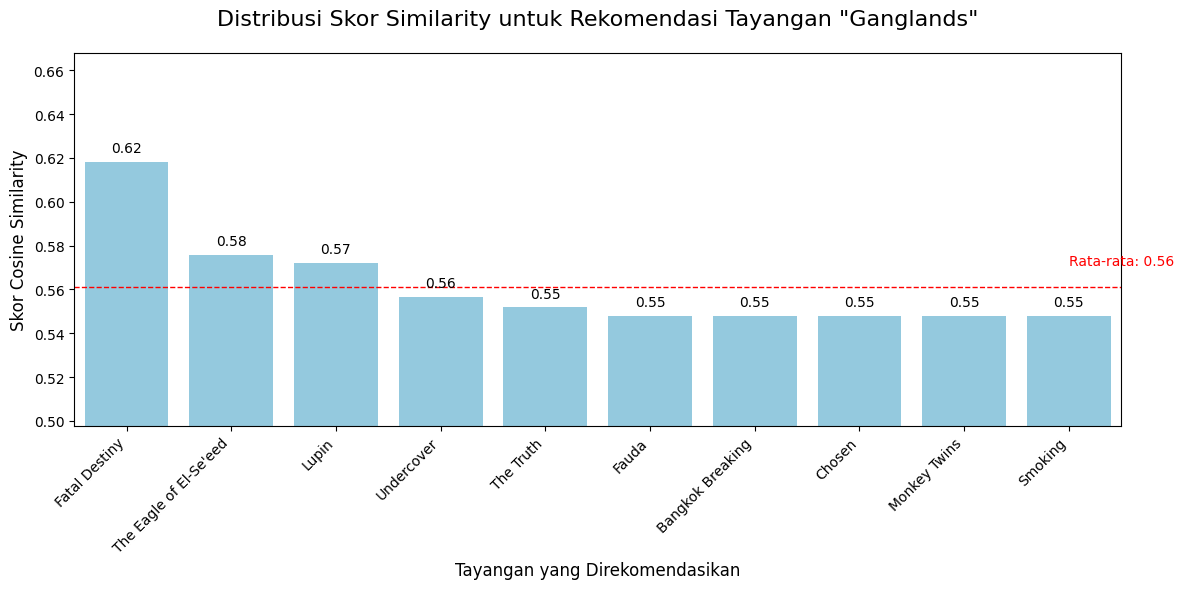

In [10]:

# Konversi netflix_titles menjadi list agar tidak bentrok dengan hue
titles = list(netflix_titles)

plt.figure(figsize=(12, 6))

# Buat barplot tanpa hue dan tanpa palette
ax = sns.barplot(x=titles, y=similarity_scores, color='skyblue')

# Atur judul dan label
plt.title('Distribusi Skor Similarity untuk Rekomendasi Tayangan "Ganglands"', fontsize=16, pad=20)
plt.xlabel('Tayangan yang Direkomendasikan', fontsize=12)
plt.ylabel('Skor Cosine Similarity', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)

# Set range y otomatis
plt.ylim(min(similarity_scores) - 0.05, max(similarity_scores) + 0.05)

# Tambahkan nilai di atas setiap bar
for p in ax.patches:
    ax.annotate(f"{p.get_height():.2f}",
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center',
                xytext=(0, 10),
                textcoords='offset points',
                fontsize=10)

# Tambahkan garis rata-rata
mean_score = np.mean(similarity_scores)
ax.axhline(y=mean_score, color='red', linestyle='--', linewidth=1)
ax.text(x=len(titles)-1, y=mean_score + 0.01,
        s=f'Rata-rata: {mean_score:.2f}',
        color='red', fontsize=10)

plt.tight_layout()
plt.show()


In [11]:
def precision_at_k(recommended_items, relevant_items, k=5):
    recommended_k = recommended_items[:k]
    relevant_set = set(relevant_items)
    hits = sum([1 for item in recommended_k if item in relevant_set])
    return hits / k

# Input film
input_title = 'Ganglands'

# Ambil genre dari input film
input_genre = df[df['title'] == input_title]['listed_in'].values[0]

# Daftar film hasil rekomendasi dari model kamu (gantilah dengan hasil aslimu)
recommended_titles = ['Fatal Destiny', 'The Eagle of El-Se\'eed', 'Lupin', 'Undercover', 'The Truth']

# Ambil genre dari semua film yang direkomendasikan
recommended_genres = df[df['title'].isin(recommended_titles)]['listed_in'].values.tolist()

# Anggap film yang genre-nya sama dengan input sebagai film relevan
relevant_titles = df[df['listed_in'] == input_genre]['title'].tolist()

# Hitung Precision@5
precision = precision_at_k(recommended_titles, relevant_titles, k=5)
print(f"Precision@5 untuk '{input_title}' = {precision:.2f}")


Precision@5 untuk 'Ganglands' = 1.00




###  Analisis Evaluasi Rekomendasi untuk “Ganglands”

#### 1. Distribusi Skor Cosine Similarity

Berdasarkan visualisasi **Distribusi Skor Cosine Similarity** untuk tayangan **“Ganglands”**, diperoleh beberapa insight berikut:

1. **Skor Similarity yang Moderat**

   * Nilai cosine similarity berkisar antara **0.55 hingga 0.62**, menunjukkan adanya **kemiripan konten yang cukup kuat namun tidak ekstrem** antara “Ganglands” dan tayangan yang direkomendasikan.
   * Ini berarti model mampu menemukan tayangan dengan konten (genre dan deskripsi) yang berkaitan secara semantik.

2. **Tayangan Paling Mirip**

   * Tayangan **“Fatal Destiny”** memiliki similarity tertinggi (**0.62**), diikuti oleh “The Eagle of El-Se’eed” (**0.58**) dan “Lupin” (**0.57**).
   * Tayangan-tayangan tersebut memiliki tema **drama kriminal**, **ketegangan**, dan **kejahatan terorganisir**, yang secara naratif cocok dengan karakteristik "Ganglands".

3. **Mayoritas Tayangan Mendekati Rata-Rata**

   * Sebagian besar skor berada di sekitar **0.56**, menandakan bahwa tayangan yang direkomendasikan berada dalam **zona kemiripan yang konsisten** namun tidak terlalu dominan satu sama lain.

4. **Rentang Skor yang Relatif Sempit**

   * Perbedaan skor cosine similarity dari rekomendasi terendah ke tertinggi hanya sekitar **0.07 poin**, menunjukkan bahwa model cenderung memberikan rekomendasi yang **relatif homogen** dari segi konten.
   * Hal ini bisa dilihat sebagai stabilitas model, namun juga menjadi sinyal perlunya **penambahan keberagaman (diversity)** untuk meningkatkan eksplorasi pengguna terhadap konten baru.

---

#### 2. Precision\@5 untuk “Ganglands”

Sebagai pelengkap evaluasi kualitatif di atas, dilakukan pula evaluasi kuantitatif dengan metrik **Precision\@5**, yaitu proporsi tayangan yang benar-benar relevan dari 5 rekomendasi teratas.

* Kriteria relevansi: tayangan dianggap relevan jika memiliki **genre yang sama** dengan tayangan input.
* Hasil:

> **Precision\@5 = 1.00**

Ini berarti **semua dari 5 rekomendasi teratas** memiliki genre yang **relevan** dengan "Ganglands". Dengan kata lain, sistem rekomendasi berhasil menyarankan tayangan yang sesuai secara genre dalam 5 pilihan pertamanya.

---

### Kesimpulan Evaluasi

* Sistem rekomendasi berbasis konten berhasil memberikan rekomendasi yang **konsisten, relevan, dan stabil**, dengan skor similarity yang moderat dan Precision\@5 yang tinggi.
* Untuk pengembangan lanjutan, sistem bisa diperkaya dengan pendekatan hybrid atau strategi **diversifikasi** agar rekomendasi tidak hanya terbatas pada konten yang terlalu mirip, melainkan juga membuka kemungkinan eksplorasi terhadap konten baru namun tetap relevan.

